# ORF recognition by LSTM
LSTM was incapable of ORF recognition on 1000 bp sequences. Try smaller.


In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-05-17 17:24:05 UTC'

In [2]:
PC_SEQUENCES=2000   # how many protein-coding sequences
NC_SEQUENCES=2000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
BASES=100            # how long is each sequence
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (BASES,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (BASES,ALPHABET) # Conv1D needs 2D inputs
NEURONS = 32
#DROP_RATE = 0.2
EPOCHS=50  # how many times to train on all the data
SPLITS=5  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=5  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_gen import *
    from SimTools.RNA_describe import *
    from SimTools.RNA_prep import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_gen():
    print("ERROR: Cannot use RNA_gen.")
if not assert_imported_RNA_prep():
    print("ERROR: Cannot use RNA_prep.")

On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import LSTM
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
# Use code from our SimTools library.
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    pcgen.set_seq_oracle(Transcript_Oracle())
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen

pc_sim,nc_sim = make_generators(BASES)
pc_train = pc_sim.get_sequences(PC_SEQUENCES)
nc_train = nc_sim.get_sequences(NC_SEQUENCES)
print("Train on",len(pc_train),"PC seqs")
print("Train on",len(nc_train),"NC seqs")

Train on 2000 PC seqs
Train on 2000 NC seqs


In [6]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [7]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=ALPHABET, output_dim=ALPHABET))
        #VOCABULARY_SIZE, EMBED_DIMEN, input_length=1000, input_length=1000, mask_zero=True)
        #input_dim=[None,VOCABULARY_SIZE], output_dim=EMBED_DIMEN, mask_zero=True)
    dnn.add(LSTM(NEURONS,return_sequences=True,input_shape=INPUT_SHAPE))
    dnn.add(LSTM(NEURONS,return_sequences=False)) 
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build() # input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (100, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 32)           4736      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 14,145
Trainable params: 14,145
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/50
100/100 [==============================] - 19s 17ms/step - loss: 0.6991 - accuracy: 0.4890 - val_loss: 0.6926 - val_accuracy: 0.5188


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6933 - accuracy: 0.5118 - val_loss: 0.6942 - val_accuracy: 0.4863
Epoch 3/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6937 - accuracy: 0.5002 - val_loss: 0.6929 - val_accuracy: 0.5038
Epoch 4/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6931 - accuracy: 0.5012 - val_loss: 0.6920 - val_accuracy: 0.5138
Epoch 5/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6921 - accuracy: 0.5192 - val_loss: 0.6881 - val_accuracy: 0.5688


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 6/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6915 - accuracy: 0.5312 - val_loss: 0.6841 - val_accuracy: 0.5537
Epoch 7/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6796 - accuracy: 0.5769 - val_loss: 0.6770 - val_accuracy: 0.5688
Epoch 8/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6740 - accuracy: 0.5942 - val_loss: 0.6664 - val_accuracy: 0.6050


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 9/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6710 - accuracy: 0.5848 - val_loss: 0.6626 - val_accuracy: 0.5987
Epoch 10/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6670 - accuracy: 0.6022 - val_loss: 0.6643 - val_accuracy: 0.6037
Epoch 11/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6680 - accuracy: 0.5884 - val_loss: 0.6678 - val_accuracy: 0.5975
Epoch 12/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6607 - accuracy: 0.6069 - val_loss: 0.6628 - val_accuracy: 0.6112


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 13/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6513 - accuracy: 0.6152 - val_loss: 0.6622 - val_accuracy: 0.6012
Epoch 14/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6569 - accuracy: 0.6165 - val_loss: 0.6565 - val_accuracy: 0.6325


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 15/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6580 - accuracy: 0.6180 - val_loss: 0.6516 - val_accuracy: 0.6338


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 16/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6513 - accuracy: 0.6158 - val_loss: 0.6445 - val_accuracy: 0.6413


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 17/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6483 - accuracy: 0.6260 - val_loss: 0.6474 - val_accuracy: 0.6200
Epoch 18/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6413 - accuracy: 0.6264 - val_loss: 0.6620 - val_accuracy: 0.6175
Epoch 19/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6452 - accuracy: 0.6417 - val_loss: 0.6430 - val_accuracy: 0.6313
Epoch 20/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6247 - accuracy: 0.6580 - val_loss: 0.6352 - val_accuracy: 0.6500


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 21/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6245 - accuracy: 0.6610 - val_loss: 0.6278 - val_accuracy: 0.6538


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 22/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6217 - accuracy: 0.6666 - val_loss: 0.6248 - val_accuracy: 0.6587


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 23/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6257 - accuracy: 0.6525 - val_loss: 0.6227 - val_accuracy: 0.6600


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 24/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6223 - accuracy: 0.6571 - val_loss: 0.6164 - val_accuracy: 0.6662


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 25/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6055 - accuracy: 0.6840 - val_loss: 0.6302 - val_accuracy: 0.6562
Epoch 26/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6281 - accuracy: 0.6479 - val_loss: 0.6102 - val_accuracy: 0.6812


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 27/50
100/100 [==============================] - 1s 9ms/step - loss: 0.5997 - accuracy: 0.6788 - val_loss: 0.6267 - val_accuracy: 0.6513
Epoch 28/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6044 - accuracy: 0.6755 - val_loss: 0.6310 - val_accuracy: 0.6612
Epoch 29/50
100/100 [==============================] - 1s 9ms/step - loss: 0.5984 - accuracy: 0.6821 - val_loss: 0.6070 - val_accuracy: 0.6938


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 30/50
100/100 [==============================] - 1s 9ms/step - loss: 0.5936 - accuracy: 0.6885 - val_loss: 0.6178 - val_accuracy: 0.6787
Epoch 31/50
100/100 [==============================] - 1s 9ms/step - loss: 0.5888 - accuracy: 0.6904 - val_loss: 0.6186 - val_accuracy: 0.6637
Epoch 32/50
100/100 [==============================] - 1s 9ms/step - loss: 0.5713 - accuracy: 0.7052 - val_loss: 0.6291 - val_accuracy: 0.6400
Epoch 33/50
100/100 [==============================] - 1s 9ms/step - loss: 0.5765 - accuracy: 0.7071 - val_loss: 0.6288 - val_accuracy: 0.6650
Epoch 34/50
100/100 [==============================] - 1s 9ms/step - loss: 0.5893 - accuracy: 0.6803 - val_loss: 0.6033 - val_accuracy: 0.6875
Epoch 35/50
100/100 [==============================] - 1s 9ms/step - loss: 0.5662 - accuracy: 0.7134 - val_loss: 0.6079 - val_accuracy: 0.6787
Epoch 36/50
100/100 [==============================] - 1s 9ms/step - loss: 0.5790 - accuracy: 0.7044 - val_loss: 0.6383 - val_accuracy: 0.6525

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 40/50
100/100 [==============================] - 1s 9ms/step - loss: 0.5555 - accuracy: 0.7229 - val_loss: 0.6064 - val_accuracy: 0.6825
Epoch 41/50
100/100 [==============================] - 1s 9ms/step - loss: 0.5484 - accuracy: 0.7203 - val_loss: 0.6064 - val_accuracy: 0.6875
Epoch 42/50
100/100 [==============================] - 1s 9ms/step - loss: 0.5426 - accuracy: 0.7302 - val_loss: 0.6169 - val_accuracy: 0.6888
Epoch 43/50
100/100 [==============================] - 1s 9ms/step - loss: 0.5244 - accuracy: 0.7525 - val_loss: 0.6326 - val_accuracy: 0.6800
Epoch 44/50
100/100 [==============================] - 1s 9ms/step - loss: 0.5251 - accuracy: 0.7395 - val_loss: 0.6239 - val_accuracy: 0.6700
Epoch 45/50
100/100 [==============================] - 1s 9ms/step - loss: 0.5398 - accuracy: 0.7395 - val_loss: 0.6210 - val_accuracy: 0.6825
Epoch 46/50
100/100 [==============================] - 1s 9ms/step - loss: 0.5206 - accuracy: 0.7508 - val_loss: 0.6285 - val_accuracy: 0.6837

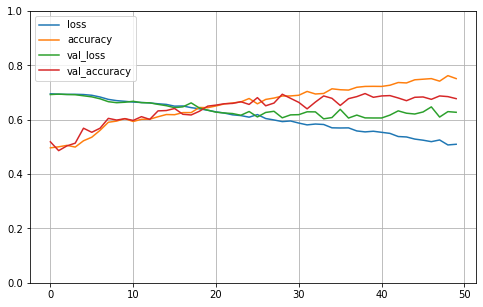

MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/50
100/100 [==============================] - 4s 19ms/step - loss: 0.6924 - accuracy: 0.5304 - val_loss: 0.6896 - val_accuracy: 0.5575
Epoch 2/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6874 - accuracy: 0.5600 - val_loss: 0.6755 - val_accuracy: 0.5888
Epoch 3/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6822 - accuracy: 0.5682 - val_loss: 0.6630 - val_accuracy: 0.6137
Epoch 4/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6761 - accuracy: 0.5720 - val_loss: 0.6653 - val_accuracy: 0.6000
Epoch 5/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6696 - accuracy: 0.6000 - val_loss: 0.6594 - val_accuracy: 0.6150
Epoch 6/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6672 - accuracy: 0.5964 - val_loss: 0.6666 - val_accuracy: 0.6000
Epoch 7/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6658 - accuracy: 0.5978 - val_

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 30/50
100/100 [==============================] - 1s 9ms/step - loss: 0.5617 - accuracy: 0.7132 - val_loss: 0.5571 - val_accuracy: 0.7300


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 31/50
100/100 [==============================] - 1s 9ms/step - loss: 0.5275 - accuracy: 0.7373 - val_loss: 0.5506 - val_accuracy: 0.7412


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 32/50
100/100 [==============================] - 1s 9ms/step - loss: 0.5020 - accuracy: 0.7611 - val_loss: 0.5444 - val_accuracy: 0.7462


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 33/50
100/100 [==============================] - 1s 9ms/step - loss: 0.4772 - accuracy: 0.7747 - val_loss: 0.4469 - val_accuracy: 0.8150


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 34/50
100/100 [==============================] - 1s 9ms/step - loss: 0.4090 - accuracy: 0.8203 - val_loss: 0.4490 - val_accuracy: 0.8000
Epoch 35/50
100/100 [==============================] - 1s 9ms/step - loss: 0.4328 - accuracy: 0.8035 - val_loss: 0.3847 - val_accuracy: 0.8338


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 36/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3837 - accuracy: 0.8252 - val_loss: 0.4358 - val_accuracy: 0.8213
Epoch 37/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3508 - accuracy: 0.8536 - val_loss: 0.4156 - val_accuracy: 0.8313
Epoch 38/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3652 - accuracy: 0.8450 - val_loss: 0.3983 - val_accuracy: 0.8325
Epoch 39/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3478 - accuracy: 0.8582 - val_loss: 0.3994 - val_accuracy: 0.8325
Epoch 40/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3262 - accuracy: 0.8710 - val_loss: 0.3716 - val_accuracy: 0.8363


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 41/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3188 - accuracy: 0.8742 - val_loss: 0.3661 - val_accuracy: 0.8413


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 42/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3173 - accuracy: 0.8629 - val_loss: 0.3689 - val_accuracy: 0.8438


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 43/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3027 - accuracy: 0.8734 - val_loss: 0.3646 - val_accuracy: 0.8413
Epoch 44/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3046 - accuracy: 0.8695 - val_loss: 0.3529 - val_accuracy: 0.8562


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 45/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3005 - accuracy: 0.8737 - val_loss: 0.3378 - val_accuracy: 0.8512
Epoch 46/50
100/100 [==============================] - 1s 9ms/step - loss: 0.2827 - accuracy: 0.8874 - val_loss: 0.3798 - val_accuracy: 0.8238
Epoch 47/50
100/100 [==============================] - 1s 9ms/step - loss: 0.2954 - accuracy: 0.8763 - val_loss: 0.3790 - val_accuracy: 0.8475
Epoch 48/50
100/100 [==============================] - 1s 9ms/step - loss: 0.2845 - accuracy: 0.8841 - val_loss: 0.3607 - val_accuracy: 0.8425
Epoch 49/50
100/100 [==============================] - 1s 9ms/step - loss: 0.2839 - accuracy: 0.8799 - val_loss: 0.3832 - val_accuracy: 0.8388
Epoch 50/50
100/100 [==============================] - 1s 9ms/step - loss: 0.2892 - accuracy: 0.8745 - val_loss: 0.3537 - val_accuracy: 0.8562
Fold 2, 50 epochs, 121 sec


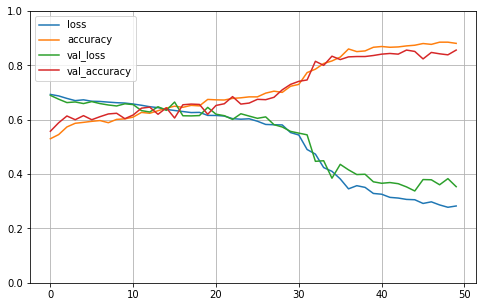

MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/50
100/100 [==============================] - 3s 15ms/step - loss: 0.6913 - accuracy: 0.5308 - val_loss: 0.6945 - val_accuracy: 0.4938
Epoch 2/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6908 - accuracy: 0.5239 - val_loss: 0.6840 - val_accuracy: 0.5962
Epoch 3/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6881 - accuracy: 0.5373 - val_loss: 0.6747 - val_accuracy: 0.6000
Epoch 4/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6831 - accuracy: 0.5563 - val_loss: 0.6653 - val_accuracy: 0.6075
Epoch 5/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6711 - accuracy: 0.5937 - val_loss: 0.6706 - val_accuracy: 0.5975
Epoch 6/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6742 - accuracy: 0.5897 - val_loss: 0.6652 - val_accuracy: 0.5975
Epoch 7/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6677 - accuracy: 0.5986 - val_

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 36/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3486 - accuracy: 0.8557 - val_loss: 0.3496 - val_accuracy: 0.8575
Epoch 37/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3529 - accuracy: 0.8487 - val_loss: 0.3441 - val_accuracy: 0.8600


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 38/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3183 - accuracy: 0.8698 - val_loss: 0.3405 - val_accuracy: 0.8587
Epoch 39/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3139 - accuracy: 0.8666 - val_loss: 0.3728 - val_accuracy: 0.8587
Epoch 40/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3604 - accuracy: 0.8526 - val_loss: 0.3374 - val_accuracy: 0.8550
Epoch 41/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3052 - accuracy: 0.8713 - val_loss: 0.3705 - val_accuracy: 0.8475
Epoch 42/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3026 - accuracy: 0.8714 - val_loss: 0.3382 - val_accuracy: 0.8637


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 43/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3066 - accuracy: 0.8697 - val_loss: 0.3498 - val_accuracy: 0.8625
Epoch 44/50
100/100 [==============================] - 1s 9ms/step - loss: 0.2986 - accuracy: 0.8820 - val_loss: 0.3256 - val_accuracy: 0.8600
Epoch 45/50
100/100 [==============================] - 1s 9ms/step - loss: 0.3012 - accuracy: 0.8738 - val_loss: 0.3596 - val_accuracy: 0.8562
Epoch 46/50
100/100 [==============================] - 1s 9ms/step - loss: 0.2968 - accuracy: 0.8736 - val_loss: 0.3402 - val_accuracy: 0.8512
Epoch 47/50
100/100 [==============================] - 1s 9ms/step - loss: 0.2863 - accuracy: 0.8762 - val_loss: 0.3301 - val_accuracy: 0.8525
Epoch 48/50
100/100 [==============================] - 1s 9ms/step - loss: 0.2677 - accuracy: 0.8908 - val_loss: 0.3288 - val_accuracy: 0.8662


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 49/50
100/100 [==============================] - 1s 9ms/step - loss: 0.2756 - accuracy: 0.8897 - val_loss: 0.3194 - val_accuracy: 0.8637
Epoch 50/50
100/100 [==============================] - 1s 9ms/step - loss: 0.2783 - accuracy: 0.8730 - val_loss: 0.3237 - val_accuracy: 0.8712


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Fold 3, 50 epochs, 85 sec


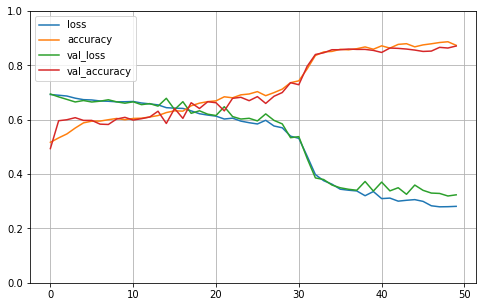

MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/50
100/100 [==============================] - 4s 15ms/step - loss: 0.7059 - accuracy: 0.4840 - val_loss: 0.6924 - val_accuracy: 0.5063
Epoch 2/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6920 - accuracy: 0.5178 - val_loss: 0.6906 - val_accuracy: 0.5437
Epoch 3/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6847 - accuracy: 0.5682 - val_loss: 0.6870 - val_accuracy: 0.5600
Epoch 4/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6791 - accuracy: 0.5814 - val_loss: 0.6903 - val_accuracy: 0.5612
Epoch 5/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6688 - accuracy: 0.5961 - val_loss: 0.6819 - val_accuracy: 0.5600
Epoch 6/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6611 - accuracy: 0.6150 - val_loss: 0.6869 - val_accuracy: 0.5663
Epoch 7/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6563 - accuracy: 0.6192 - val_

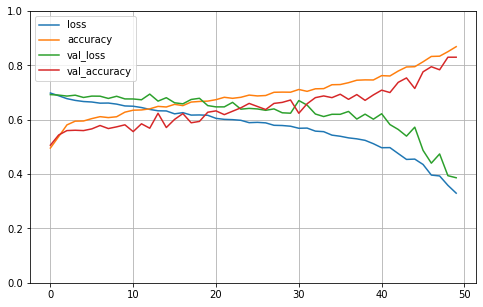

MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/50
100/100 [==============================] - 4s 23ms/step - loss: 0.6946 - accuracy: 0.5025 - val_loss: 0.6909 - val_accuracy: 0.5400
Epoch 2/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6875 - accuracy: 0.5578 - val_loss: 0.6844 - val_accuracy: 0.5537
Epoch 3/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6813 - accuracy: 0.5620 - val_loss: 0.6732 - val_accuracy: 0.5813
Epoch 4/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6658 - accuracy: 0.6023 - val_loss: 0.6702 - val_accuracy: 0.5938
Epoch 5/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6664 - accuracy: 0.5896 - val_loss: 0.6732 - val_accuracy: 0.5675
Epoch 6/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6603 - accuracy: 0.6001 - val_loss: 0.6629 - val_accuracy: 0.5962
Epoch 7/50
100/100 [==============================] - 1s 9ms/step - loss: 0.6576 - accuracy: 0.6083 - val_

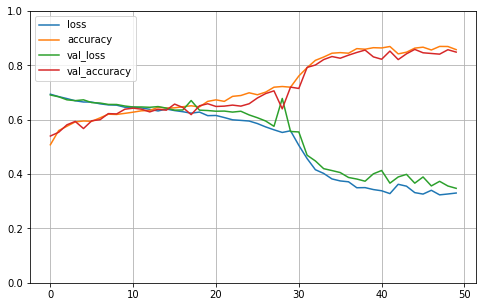

In [9]:
do_cross_validation(X,y)

In [10]:
from keras.models import load_model
pc_sim.set_reproducible(True)
nc_sim.set_reproducible(True)
pc_test = pc_sim.get_sequences(PC_TESTS)
nc_test = nc_sim.get_sequences(NC_TESTS)
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 86.45%


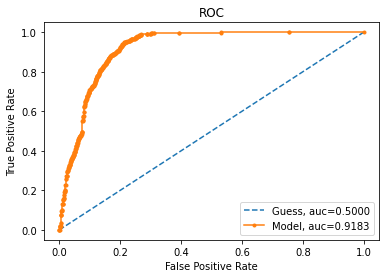

AUC: 0.92%


In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc))


In [12]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-05-17 17:32:20 UTC'